In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import odl
from odl.contrib.torch import OperatorModule
from odl.contrib import torch as odl_torch
from torch.nn.utils import clip_grad_norm_
import numpy as np
import matplotlib.pyplot as plt
from functions import create_operator_and_space, random_gf_pair, Dual_Network, Primal_Network, Architecture

In [6]:
primal_shape = (64,64)
dual_shape = (64,64)
primal_space, dual_space, forward_operator, adjoint_operator = create_operator_and_space(primal_shape, dual_shape)



# Generating data

N_train = 1000
N_test = 10
amount_of_data = N_train + N_test

g = torch.zeros((amount_of_data, ) + dual_shape)
x = torch.zeros((amount_of_data, ) + primal_shape)

for k in range(amount_of_data):
    x[k,:,:], g[k,:,:] = random_gf_pair(primal_space, dual_space, forward_operator, noise_level=0.01)


#x = torch.tensor(x)
#g = torch.tensor(g)

g = g[:, None, :, :].to('cuda')
x = x[:, None, :, :].to('cuda')

g_train = g[0:N_train]
g_test = g[N_train:]

x_train = x[:N_train]
x_test = x[N_train:]


iterations = 10
Dual_nets = [Dual_Network(7, 5) for i in range(iterations)]
#Dual_nets = [Dual_Network(7, 5),] * iterations
Primal_nets = [Primal_Network(6, 5) for i in range(iterations)]
#Primal_nets = [Primal_Network(6, 5),] * iterations

LPDnet = Architecture(forward_operator, adjoint_operator, Primal_nets, Dual_nets, (5, primal_shape[0], primal_shape[1]), (5, dual_shape[0], dual_shape[1]), iterations)

LPD_params = (LPDnet.parameters())


def loss_function(g, f_values):
    #loss = torch.mean(torch.linalg.norm(g - f_values)**2)
    loss = torch.mean((g - f_values)**2)
    return loss


def eval(net, loss_function, g, x):

    test_loss = []

    net.eval()

    test_loss.append(torch.sqrt(loss_function(net(g), x[:, None, :, :][0:9])).item())

    print(test_loss)

    func = net(g[0,None,:,:])

    return func


running_loss = []
running_test_loss = []

def train_network(net, loss_function, x, n_train=190):


    optimizer = optim.Adam((LPDnet.parameters()), lr=0.001, betas = (0.9, 0.99))
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)

    net.train()

    for i in range(n_train):

        n_index = np.random.permutation(g_train.shape[0])[:5]
        g_batch = g_train[n_index]
        x_batch = x[n_index]
        outs = net(g_batch)
        
        loss = loss_function(x_batch, outs)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(LPD_params, max_norm=1.0, norm_type=2)
        optimizer.step()
        # scheduler.step()
        
        #running_loss.append(loss.item())

        if i % 10 == 0:
            test_loss = loss_function(x_test, net(g_test)).item()**0.5
            train_loss = loss.item() ** 0.5
            running_loss.append(train_loss)
            running_test_loss.append(test_loss)
            print(f'Iter {i}/{n_train} Train Loss: {train_loss:.2e}, Test Loss {test_loss:.2e}', end='\r')


    return running_loss, running_test_loss, net


running_loss, running_test_loss, test = train_network(LPDnet, loss_function, x_train, n_train=5000)


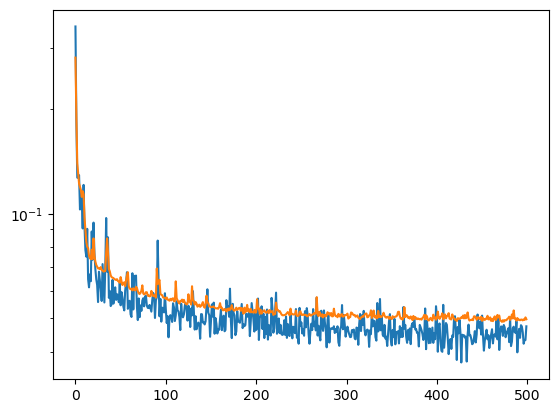

In [ ]:
plt.semilogy(running_loss)
plt.semilogy(running_test_loss)

[0.25902557373046875]


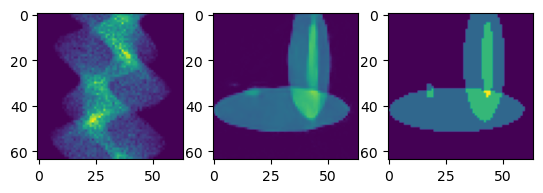

In [ ]:
#test_data = g[99:109]
# print(np.shape(test_data))
# print(len(test_data))
func = eval(LPDnet, loss_function, g_test, x_test)

it = 3
func = LPDnet(g_test[None, it, :, :, :])[0,0,:,:].cpu().detach().numpy()
orig = x_test[it, 0, :, :].cpu().detach().numpy()
noisy = g_test[it, 0, :, :].cpu().detach().numpy()

plt.figure()

plt.subplot(1,3,1)
plt.imshow(noisy)

plt.subplot(1,3,2)
plt.imshow(func, vmin=0, vmax=1.)

plt.subplot(1,3,3)
plt.imshow(orig, vmin=0, vmax=1.)

plt.show()